In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py

In [3]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap

In [4]:
N = lambda a: a/median(a)

In [117]:
class LPFC(LPF):
    def __init__(self, use_ldtk=False, constant_k=True, noise='white'):
        pbs = 'g r i z'.split()
        cols = ['relative_'+c for c in pbs]
        

        self.df2 = df2 = pd.merge(pd.read_hdf('../data/aux.h5','aug25'),
                                  pd.read_hdf('../results/gtc_light_curves.h5','broadband/night2'),
                                  left_index=True, right_index=True)
        
        times = [df2['mjd-obs'].values+2400000.5-TZERO]
        fluxes = [df2[cols].values.mean(1)]
        
        super(LPFC,self).__init__(times, fluxes, ['w'], 
                                  use_ldtk=False, constant_k=constant_k, noise=noise)
        
        ## Mask outliers
        ## -------------
        masks = []
        for i,f in enumerate(self.fluxes):
            mask = abs(f-MF(f,11)) < 0.003
            if i==-1:
                mask &= (self.times[0] < 855.528) | (self.times[0] > 855.546)
            masks.append(mask)
        
        self.times   = [t[m] for t,m in zip(self.times, masks)]
        self.fluxes  = [f[m] for f,m in zip(self.fluxes, masks)]
        self.rotang  = [df2.rotang[masks[0]]]
        self.elevat  = [df2.elevat[masks[0]]]
        self.airmass = [df2.airmass[masks[0]]]
        self.ctimes  = [t-t.mean() for t in self.times]
        
        ## Setup priors
        ## ------------
        ## Basic parameters
        ## ----------------
        self.priors = [NP(    TC,   5e-3,   'tc'), ##  0  - Transit centre
                       NP(     P,   3e-4,    'p'), ##  1  - Period
                       UP(  3.50,   4.50,  'rho'), ##  2  - Stellar density
                       UP(  0.00,   0.99,    'b')] ##  3  - Impact parameter
        
        ## Area ratio
        ## ----------
        self._sk2 = len(self.priors)
        if constant_k:
            self.priors.append( UP(0.16**2, 0.18**2, 'k2')) ##  4  - planet-star area ratio
        else:
            self.priors.extend([UP(0.16**2, 0.18**2, 'k2_%i'%ipb) 
                                for ipb in range(self.npb)]) ##  4  - planet-star area ratio
            
        ## Limb darkening
        ## --------------
        self._sq1 = len(self.priors)
        self._sq2 = self._sq1+1
        for ipb in range(self.npb):
            self.priors.extend([UP(0, 1, 'q1_%i'%ipb),      ##  sq1 + 2*ipb -- limb darkening q1
                                UP(0, 1, 'q2_%i'%ipb)])     ##  sq2 + 2*ipb -- limb darkening q2
            
        ## Baseline constant
        ## -----------------
        self._sbl = len(self.priors)
        for ilc in range(self.nlc):
            self.priors.append(NP(1, 0.01,  'bla_%i'%ilc)) ##  sbl + ilc -- Baseline constant
            self.priors.append(NP(0, 0.15,  'blb_%i'%ilc)) ##  sbl + ilc -- Linear time trend
            self.priors.append(NP(0, 0.015, 'blr_%i'%ilc)) ##  sbl + ilc -- Linear rotator angle trend
            self.priors.append(NP(0, 0.015, 'blz_%i'%ilc)) ##  sbl + ilc -- Linear airmass trend

        ## White noise
        ## -----------
        self._swn = len(self.priors)
        if noise == 'white':
            self.priors.extend([UP(1e-4, 1e-2, 'e_%i'%ilc) 
                                for ilc in range(self.nlc)]) ##  sqn + ilc -- Average white noise
        #else:
        #    self.priors.extend([UP(-3, -2,  'log10_na'),
        #                        UP(1e-4, 1, 'its'),
        #                        UP(-3.5, -3, 'log10_wn')])

            
        self.ps = PriorSet(self.priors)
        self.set_pv_indices()
        
        fc = pd.read_hdf(join('..',result_file), 'ckrn_ldtk/fc')
        self.priors[0] = NP(fc.tc.mean(),   7*fc.tc.std(),  'tc',  limsigma=100)
        self.priors[1] = NP(fc.p.mean(),    7*fc.p.std(),   'p',   limsigma=100)
        self.priors[2] = NP(fc.rho.mean(),  fc.rho.std(), 'rho', limsigma=100)
        self.priors[3] = NP(fc.b.mean(),    fc.b.std(),   'b',   lims=(0,1))
        
        if constant_k:
            self.priors[4] = NP(fc.k2.mean(),   fc.k2.std(), 'k2',   limsigma=100)
        else:
            for i in self.ik2:
                self.priors[i] = NP(fc.k2.mean(), fc.k2.std(), 'k2_%i'%i,   limsigma=100)
                
        if noise == 'white':
            for i in self.iwn:
                self.priors[i] = UP(1e-4, 1e-3, 'e_%i'%i)
                    
        self.ps = PriorSet(self.priors)
        
        self.setup_gp()
        
        
    def set_pv_indices(self, sbl=None, swn=None):
        if self.constant_k:
            self.ik2 = [self._sk2]
        else:
            self.ik2 = [self._sk2+pbid for pbid in self.gpbids]
                        
        self.iq1 = [self._sq1+pbid*2 for pbid in self.gpbids]
        self.iq2 = [self._sq2+pbid*2 for pbid in self.gpbids]
        
        sbl = sbl if sbl is not None else self._sbl
        self.ibla = [sbl+4*ilc   for ilc in range(self.nlc)]
        self.iblb = [sbl+4*ilc+1 for ilc in range(self.nlc)]
        self.iblc = [sbl+4*ilc+2 for ilc in range(self.nlc)]
        self.ibld = [sbl+4*ilc+3 for ilc in range(self.nlc)]
        
        if self.noise == 'white':
            swn = swn if swn is not None else self._swn
            self.iwn = [swn+ilc for ilc in range(self.nlc)]
        #else:
        #    swn = swn if swn is not None else self._swn
        #    self.ina = [swn]
        #    self.its = [swn+1]
        #    self.iwn = [swn+2]
        #    self._slgp = s_[swn:swn+3]

        
    def setup_gp(self):
        self.gps = [GPTime(t,f) for t,f in zip(self.times, self.fluxes)]
        #[gp.compute([-2.6, 5e-2, -3.2]) for i,gp in enumerate(self.gps)]
        [gp.compute([-2.27, 0.3, -2.9]) for i,gp in enumerate(self.gps)]
        
    def lnlikelihood_rn(self, pv):
        #[gp.compute(pv[self._slgp]) for i,gp in enumerate(self.gps)]
        flux_m = self.compute_lc_model(pv)
        return sum([gp.gp.lnlikelihood(fo-fm) for gp,fo,fm in zip(self.gps,self.fluxes,flux_m)])
        
        
    def compute_baseline(self, pv):
        return [pv[ia] + pv[ib]*t + pv[ic]*r + pv[iz]*(z-1.25) for ia,ib,ic,iz,t,r,z in 
                zip(self.ibla,self.iblb,self.iblc,self.ibld,self.ctimes,self.rotang,self.airmass)]

In [118]:
lpf = LPFC(noise='red', constant_k=True)

In [119]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 100, maximize=True)
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')
sample = permutation(fc)[:de.n_pop]
de._population[:, 0:5] = sample[:,0:5]
de._population[:,lpf.ibla] = normal(1, 1e-2, size=(de.n_pop, lpf.nlc))
de._population[:,lpf.iblc] = normal(0, 1e-5, size=(de.n_pop, lpf.nlc))

In [120]:
de.F = 0.45
de.C = 0.25

(array([  4.,  12.,  16.,  15.,  20.,  18.,   6.,   3.,   3.,   3.]),
 array([-3353.00589888, -3352.87547461, -3352.74505033, -3352.61462606,
        -3352.48420178, -3352.35377751, -3352.22335324, -3352.09292896,
        -3351.96250469, -3351.83208041, -3351.70165614]),
 <a list of 10 Patch objects>)

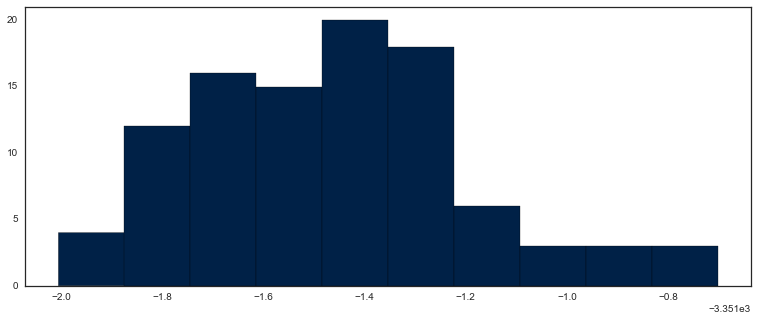

In [132]:
de.optimize(75)
hist(de._fitness)

In [79]:
from scipy.optimize import fmin, fmin_powell

In [130]:
pv = fmin_powell(lambda pv: -lpf.lnposterior(pv), de.minimum_location)

Optimization terminated successfully.
         Current function value: -3352.420087
         Iterations: 2
         Function evaluations: 374


3352.42008743


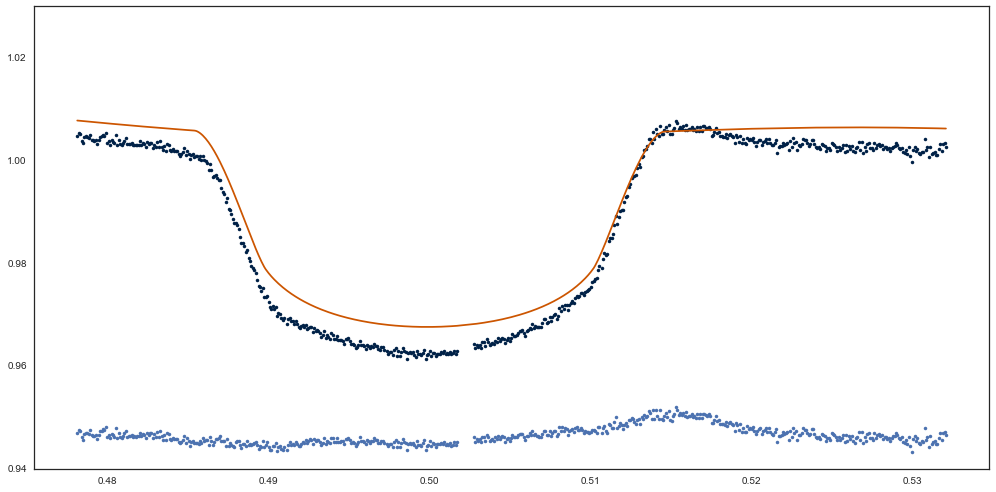

In [131]:
pv = de.minimum_location.copy()
print lpf.lnposterior(pv)
#print lpf.lnlikelihood(pv)
#pv[0] -= 0.0025
#pv[1] -= 1e-5
#print lpf.lnposterior(pv)
#print lpf.lnlikelihood(pv)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(1,1,figsize=(14,7))
phase = fold(lpf.times[0], pv[1], pv[0], 0.5)
res = fos[0]-fms[0]
axs.plot(phase, fos[i], '.')
axs.plot(phase, fms[i])
axs.plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

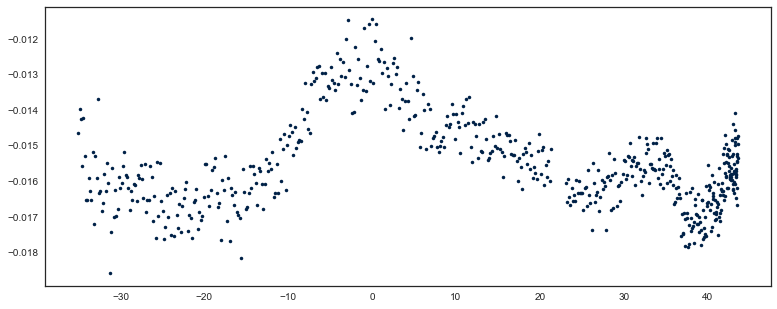

In [49]:
plot(lpf.rotang[0],fos[0]-fms[0]-0.012, '.')

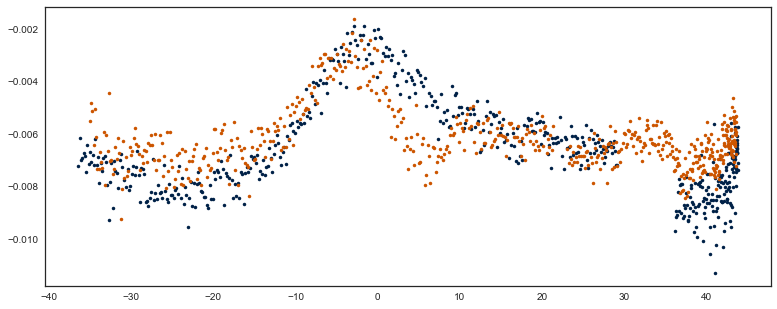

In [266]:
plot(lpf.rotang[0],fos[0]-fms[0]-0.012, '.')
plot(lpf.rotang[1],fos[1]-fms[1], '.')

In [267]:
gp = GPTime(lpf.rotang[0], (fos[0]-fms[0]).values)
gp.flux -= gp.flux.mean()

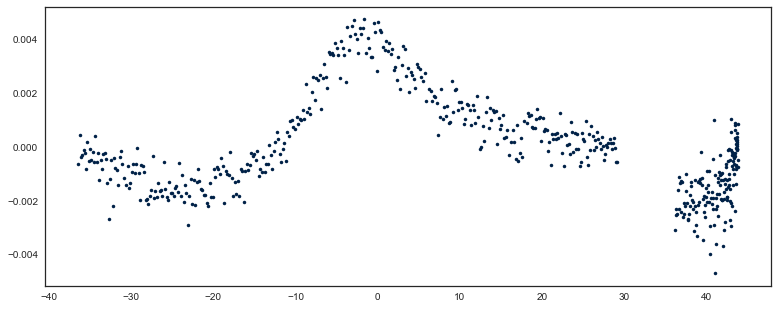

In [268]:
plot(lpf.rotang[0], gp.flux, '.')

In [269]:
from scipy.optimize import fmin

In [275]:
def minfun(pv):
    gp.compute(pv)
    return -gp.gp.lnlikelihood(gp.flux)

In [276]:
pvf = fmin(minfun, [-2.7, 1e-3, -3])
pvf

Optimization terminated successfully.
         Current function value: -3170.159530
         Iterations: 47
         Function evaluations: 92


array([ -2.78445566e+00,   9.56512844e-04,  -3.22432858e+00])

3170.1595298


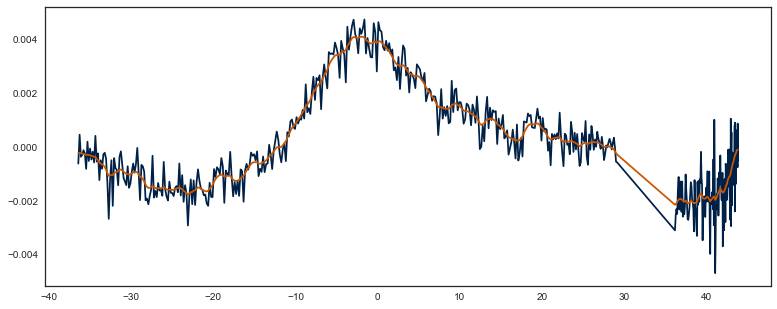

In [277]:
pv = [-2.7, 1e-3, -3]
gp.compute(pvf)
print gp.gp.lnlikelihood(gp.flux)
plot(gp.inputs, gp.flux)
plot(gp.inputs, gp.predict())

In [280]:
pr = gp.gp.predict(gp.flux, lpf.rotang[1], mean_only=True)

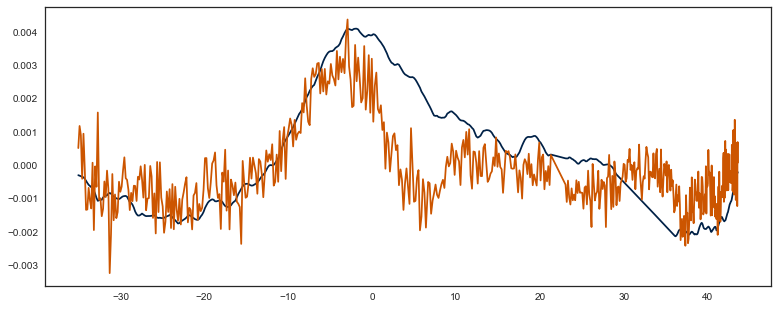

In [285]:
plot(lpf.rotang[1], pr)
plot(lpf.rotang[1], fos[1]-fms[1]+0.006)

plot(lpf.rotang[0], fos[0]-fms[0], '.')
plot(lpf.rotang[1], fos[1]-fms[1]+0.003, '.')

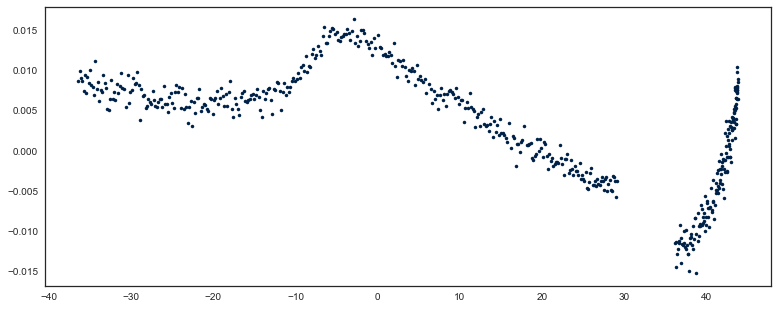

In [222]:
plot(lpf.rotang, sum(fos[1:],0)-sum(fms[1:],0), '.')

In [213]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [214]:
sampler.run_mcmc(de.population, 25);

In [215]:
sampler.run_mcmc(sampler.chain[:,-1,:], 225);

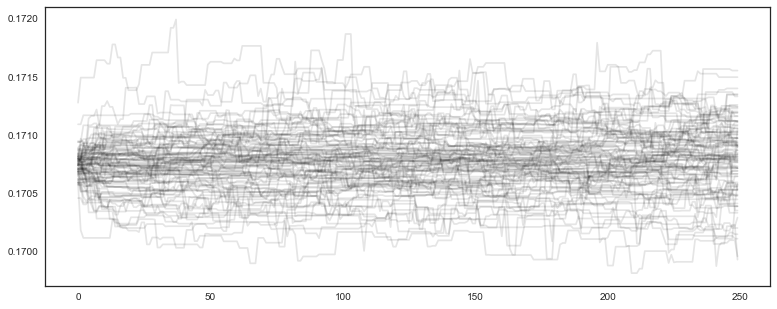

In [216]:
plot(sqrt(sampler.chain[:,:,4].T), 'k', alpha=0.1);

In [217]:
dff = pd.DataFrame(sampler.chain[:,100::10,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)